In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, matthews_corrcoef, balanced_accuracy_score, confusion_matrix
from sklearn.utils import shuffle
from sklearn.dummy import DummyClassifier

pd.set_option('display.precision', 3)

In [ ]:
import sys
if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/gdrive')
    file_path = "/content/gdrive/MyDrive/Hydrogenase/MachineLearning/JNs/"
else:
    file_path = "./"

data = pd.read_csv(file_path+'Df_H2ase_CO.csv')
data.shape

data = data.drop(["Trajectory", "Frame", "Binary"], axis=1)

X = data.drop('Pathway-new', axis=1)  # Features
y = data['Pathway-new']  # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1)
X_train.shape, X_test.shape

Mounted at /content/gdrive


((577, 804), (248, 804))

In [ ]:
data = pd.read_csv(file_path+'Mdg_H2ase_CO.csv')
data = data.drop(["Trajectory", "Frame", "Binary"], axis=1)

X_NewCO = data.drop('Pathway-new', axis=1)  # Features
y_NewCO = data['Pathway-new']  # Target variable

In [ ]:
data = pd.read_csv(file_path+'Df_H2ase_O2.csv')
data = data.drop(["Trajectory", "Frame", "Binary"], axis=1)

X_O2 = data.drop('Pathway-new', axis=1)  # Features
y_O2 = data['Pathway-new']  # Target variable

In [ ]:
data = pd.read_csv(file_path+'Df_H2ase_H2.csv')
data = data.drop(["Trajectory", "Frame", "Binary"], axis=1)

X_H2 = data.drop('Pathway-new', axis=1)  # Features
y_H2 = data['Pathway-new']  # Target variable

In [ ]:
oversampler = RandomOverSampler(random_state=1)

X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)

In [ ]:
def calc_metrics(y, y_pred):
    acc = accuracy_score(y, y_pred)
    ba = balanced_accuracy_score(y, y_pred)
    mcc = matthews_corrcoef(y, y_pred)
    cm = confusion_matrix(y, y_pred)
    return(acc, ba, mcc, cm)

def plot_heatmap(cm, classes, title, ax=None, adjust_yticks=False):
    if not ax:
        _, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=True, ax=ax,
                xticklabels=classes, yticklabels=classes, annot_kws={"fontsize":11, "fontweight":"bold"})
    ax.set_xlabel('Predicted', fontsize=12)
    ax.set_ylabel('Observed', fontsize=12)
    if adjust_yticks:
        ax.tick_params(axis='y', rotation=0)
    ax.set_title(title, fontsize=14)

In [ ]:
rfc_mdl = RandomForestClassifier(n_estimators=500, max_depth=20, ccp_alpha=0.0007,
                                 max_samples=0.95, oob_score=True,
                                 random_state=1).fit(X_train_resampled, y_train_resampled)

In [ ]:
# calculate and display the results
ds_names = ["Df-H2ase-CO-train", "Df-H2ase-CO-test", "Df-H2ase-H2-test", "Df-H2ase-O2-test", "Mdg-H2ase-CO-test"]
ds_names_formatted = ['Training Set', 'Df-H$_2$ase-CO Test Set','Df-H$_2$ase-H$_2$ Test Set', 'Df-H$_2$ase-O$_2$ Test Set','Mdg-H$_2$ase-CO Test Set']
ds_features = [X_train, X_test, X_H2, X_O2, X_NewCO]
ds_target = [y_train, y_test, y_H2, y_O2, y_NewCO]

results_dict = {}

for i in range(len(ds_names)):
    y_pred = rfc_mdl.predict(ds_features[i])
    acc, ba, mcc, cm = calc_metrics(ds_target[i], y_pred)
    results_dict[ds_names[i]] = [y_pred, acc, ba, mcc, cm]

results_df = pd.DataFrame.from_dict(results_dict, orient="index",
                                    columns=["predictions", "accuracy", "BA", "MCC", "CM"])

display(results_df.loc[:,["accuracy", "BA", "MCC"]])

del y_pred, acc, ba, mcc, cm

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


,accuracy,BA,MCC
Df-H2ase-CO-train,0.988,0.997,0.983
Df-H2ase-CO-test,0.794,0.610,0.709
Df-H2ase-H2-test,0.784,0.719,0.690
Df-H2ase-O2-test,0.707,0.738,0.492
Mdg-H2ase-CO-test,0.813,0.517,0.667


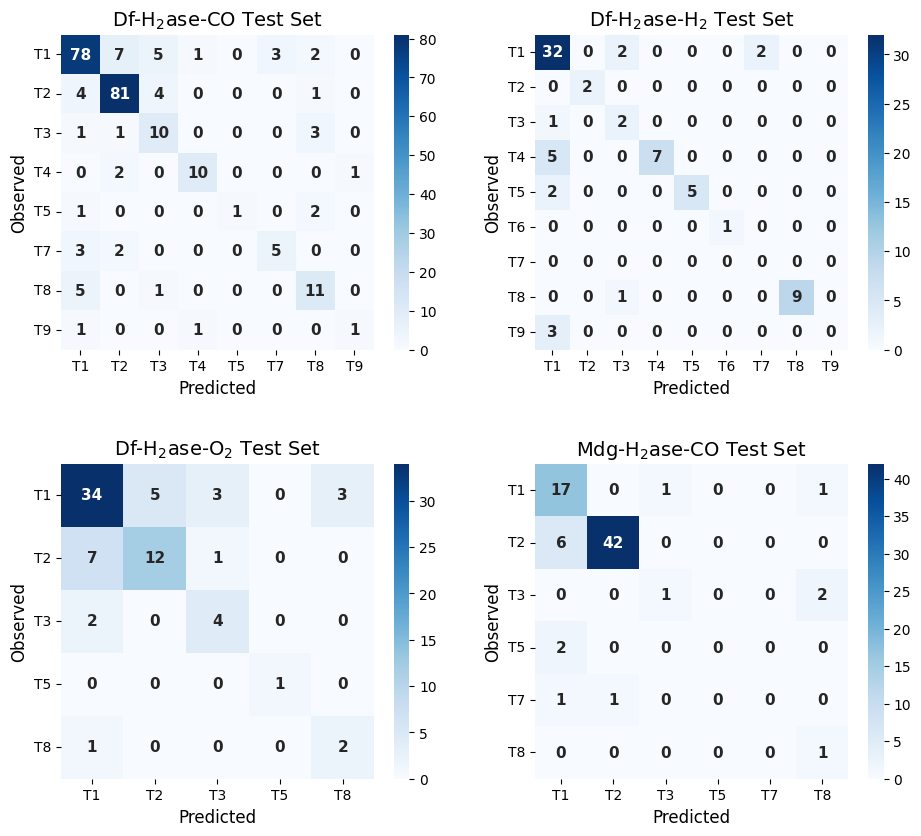

In [ ]:
# make a figure space for 4 subplots (skip training set)
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 9))
k = 0
for i, j in np.ndindex(axes.shape):
    # fetch the subplot by its coordinates in the figure space
    ax = axes[i,j]
    all_labels = sorted(set(list(results_df.iloc[k+1,0]) + list(ds_target[k+1])))
    plot_heatmap(results_df.iloc[k+1,-1], all_labels, ds_names_formatted[k+1],
                 ax, adjust_yticks=True)
    k += 1
fig.tight_layout(pad=3)
plt.show()

In [ ]:
# Instantiate the DummyClassifier
dummy_clf = DummyClassifier(strategy="most_frequent", random_state=1)

# Fit the model on the resampled training data
dummy_clf.fit(X_train_resampled, y_train_resampled)

# Predict on the test set
y_pred_dummy = dummy_clf.predict(X_test)

# Assess accuracy on the test set
balanced_accuracy_test_dummy = balanced_accuracy_score(y_test, y_pred_dummy)
mcc_test_dummy = matthews_corrcoef(y_test, y_pred_dummy)

print(f'Baseline (Dummy Classifier) Balanced Accuracy on the test set: {balanced_accuracy_test_dummy:.2f}')
print(f'Baseline (Dummy Classifier) Matthews Correlation Coefficient on the test set: {mcc_test_dummy:.2f}')

# Predict on the training set
y_pred_train_dummy = dummy_clf.predict(X_train)

# Assess accuracy on the training set
balanced_accuracy_train_dummy = balanced_accuracy_score(y_train, y_pred_train_dummy)
mcc_train_dummy = matthews_corrcoef(y_train, y_pred_train_dummy)

print(f'Baseline (Dummy Classifier) Balanced Accuracy on the training set: {balanced_accuracy_train_dummy:.2f}')
print(f'Baseline (Dummy Classifier) Matthews Correlation Coefficient on the training set: {mcc_train_dummy:.2f}')

Baseline (Dummy Classifier) Balanced Accuracy on the test set: 0.12
Baseline (Dummy Classifier) Matthews Correlation Coefficient on the test set: 0.00
Baseline (Dummy Classifier) Balanced Accuracy on the training set: 0.11
Baseline (Dummy Classifier) Matthews Correlation Coefficient on the training set: 0.00


In [ ]:
y_train_scrambled = shuffle(y_train, random_state=1)
X_train_scram_resampled, y_train_scram_resampled = oversampler.fit_resample(X_train, y_train_scrambled)

rfc_scram = RandomForestClassifier(n_estimators=500, oob_score=True, max_samples=0.95, ccp_alpha=0.0007, max_depth=20, random_state=1)
rfc_scram.fit(X_train_scram_resampled, y_train_scram_resampled)

# Predict on the training set with scrambled labels
y_pred_train_scrambled = rfc_scram.predict(X_train)
y_scram_pred_test = rfc_scram.predict(X_test)

# Assess accuracy on the training set with scrambled labels
balanced_accuracy_train_scrambled = balanced_accuracy_score(y_train_scrambled, y_pred_train_scrambled)
mcc_train_scrambled = matthews_corrcoef(y_train_scrambled, y_pred_train_scrambled)
balanced_accuracy_test_scrambled = balanced_accuracy_score(y_test, y_scram_pred_test)
mcc_test_scrambled = matthews_corrcoef(y_test, y_scram_pred_test)

print(f'Scrambled Balanced Accuracy on the training set: {balanced_accuracy_train_scrambled:.2f}')
print(f'Scrambled Matthews Correlation Coefficient on the training set: {mcc_train_scrambled:.2f}')
print(f'Scrambled Balanced Accuracy on the test set: {balanced_accuracy_test_scrambled:.2f}')
print(f'Scrambled Matthews Correlation Coefficient on the test set: {mcc_test_scrambled:.2f}')

Scrambled Balanced Accuracy on the training set: 1.00
Scrambled Matthews Correlation Coefficient on the training set: 0.99
Scrambled Balanced Accuracy on the test set: 0.17
Scrambled Matthews Correlation Coefficient on the test set: 0.12


### Convert the Multiclass Predictions to Binary Labels

- Evaluate the binary separation effectiveness of the multiclass model.

In [ ]:
# convert the multiclass predictions to binary labels
# calculate the binary prediction metrics
ds_target_binary = []
# binpred_sets = []
# binmet_sets = []
results_dict_binary = {}
for i in range(5):
    binlbl = ["Primary" if lbl in ["T1", "T2", "T7"] else "Secondary" for lbl in ds_target[i]]
    binpred = ["Primary" if lbl in ["T1", "T2", "T7"] else "Secondary" for lbl in results_df.iloc[i,0]]
    acc, ba, mcc, cm = calc_metrics(binlbl, binpred)
    results_dict_binary[ds_names[i]] = [binpred, acc, ba, mcc, cm]
    ds_target_binary.append(binlbl)

results_df_binary = pd.DataFrame.from_dict(results_dict_binary, orient="index",
                                 columns=["predictions", "accuracy", "BA", "MCC", "CM"])

display(results_df_binary.loc[:,["accuracy", "BA", "MCC"]])

del binlbl, binpred, acc, ba, mcc, cm

,accuracy,BA,MCC
Df-H2ase-CO-train,0.997,0.998,0.989
Df-H2ase-CO-test,0.903,0.861,0.712
Df-H2ase-H2-test,0.824,0.821,0.666
Df-H2ase-O2-test,0.867,0.796,0.517
Mdg-H2ase-CO-test,0.947,0.819,0.638


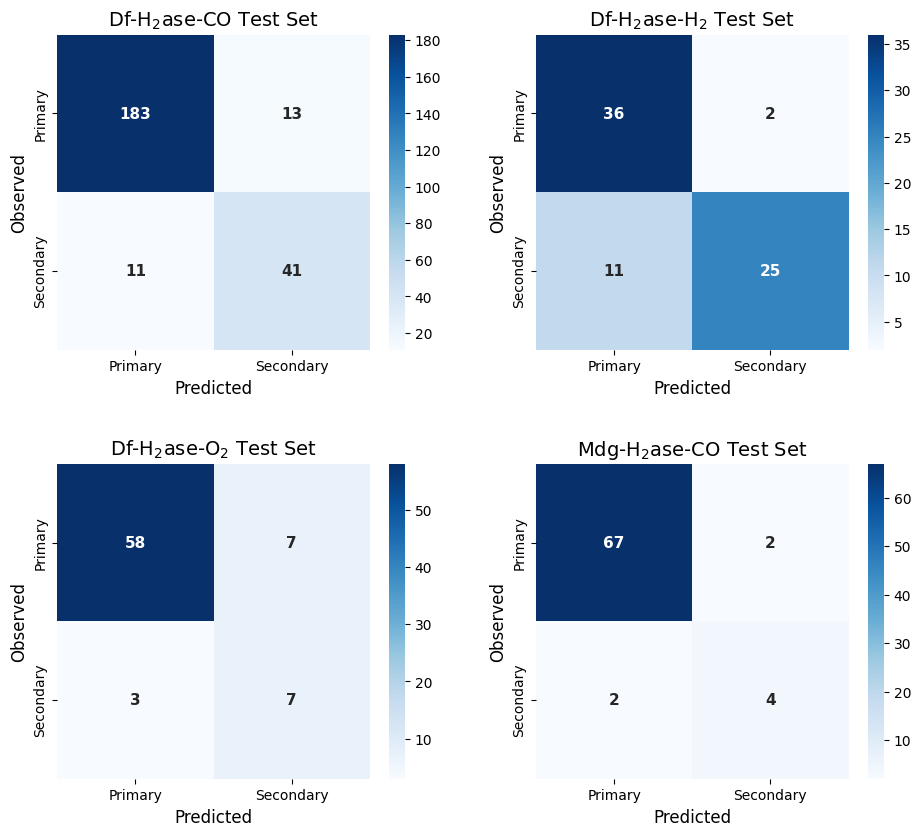

In [ ]:
# make a figure space for 4 subplots (skip training set)
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 9))
k = 0
for i, j in np.ndindex(axes.shape):
    # fetch the subplot by its coordinates in the figure space
    ax = axes[i,j]
    all_labels = sorted(set(list(results_df_binary.iloc[k+1,0]) + list(ds_target_binary[k+1])))
    plot_heatmap(results_df_binary.iloc[k+1,-1], all_labels, ds_names_formatted[k+1],
                 ax, adjust_yticks=False)
    k += 1
fig.tight_layout(pad=3)
#plt.savefig('Multi-Binary-Predict-CM.jpg', dpi=300, format='jpg')
plt.show()

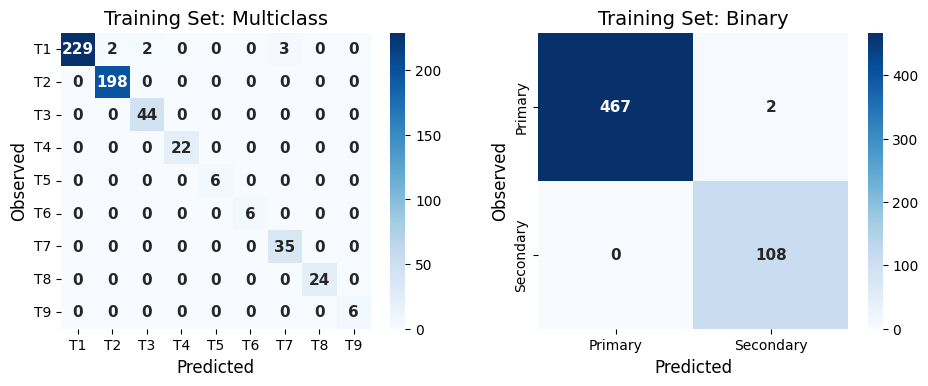

In [ ]:
mc_labels = sorted(set(list(results_df.iloc[0,0]) + list(ds_target[0])))
bin_labels = ["Primary", "Secondary"]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4.5))
plot_heatmap(results_df.iloc[0,-1], mc_labels, "Training Set: Multiclass",
             axes[0], adjust_yticks=True)
plot_heatmap(results_df_binary.iloc[0,-1], bin_labels, "Training Set: Binary",
             axes[1])
plt.tight_layout(pad=3)